# Using Label Studio for Annotations with Pixeltable

This tutorial demonstrates how to integrate Pixeltable with Label Studio, in order to provide seamless management of annotations data across the annotation workflow.

We'll assume that you're at least somewhat familiar with Pixeltable and have read the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/image-operations/) tutorial. You'll also need to have a Label Studio instance installed and running locally (or at some URL that's accessible to your installation).

This tutorial is more complex than the other Pixeltable tutorials, because it requires a running Label Studio instance to integrate with. It's best to run it in a local Pixeltable installation, rather than a Colab or Kaggle notebook. See the [Installation Guide](https://pixeltable.readme.io/docs/installation) for instructions on how to set one up.

To begin, let's ensure the requisite dependencies are installed.

In [ ]:
%pip install -q pixeltable label-studio-sdk

## Configure Pixeltable

Next we configure Pixeltable to communicate with Label Studio. You'll need to know the URL of your Label Studio installation (for a local install, it's usually http://localhost:8080/) and your API key (the "Access Token" under Account & Settings).

Then run the following command, substituting your URL and API key as appropriate.

In [1]:
import getpass
import os

if 'LABEL_STUDIO_URL' not in os.environ:
    os.environ['LABEL_STUDIO_URL'] = getpass.getpass('Label Studio URL: ')

if 'LABEL_STUDIO_API_KEY' not in os.environ:
    os.environ['LABEL_STUDIO_API_KEY'] = getpass.getpass('Label Studio API key: ')

Label Studio URL:  ········
Label Studio API key:  ········


## Create a Table to Store Videos

Now we create the master table that will hold our videos to be annotated. This only needs to be done once, when we initially set up the workflow.

In [3]:
import pixeltable as pxt

schema = {
    'video': pxt.VideoType(),
    'date': pxt.TimestampType()
}

pxt.create_dir('ls_demo', ignore_errors=True)
videos_table = pxt.create_table('ls_demo.videos', schema)

Created table `videos`.


## Populate It with Data

Now let's add some videos to the table to populate it. You can refer to input videos either by a local filename or a URL; for this tutorial, we'll use some randomly selected videos from the Multimedia Commons archive. The table also contains a `date` field, for which we'll use a fixed date (but in a production setting, it would typically be the date on which the video was imported).

In [4]:
from datetime import date

files = [
    's3://multimedia-commons/data/videos/mp4/122/8ff/1228ff94bf742242ee7c88e4769ad5d5.mp4',
    's3://multimedia-commons/data/videos/mp4/2cf/a20/2cfa205eae979b31b1144abd9fa4e521.mp4',
    's3://multimedia-commons/data/videos/mp4/ffe/ff3/ffeff3c6bf57504e7a6cecaff6aefbc9.mp4',
]
today = date(2022, 4, 22)
videos_table.insert({'video': file, 'date': today} for file in files)

Inserting rows into `videos`: 3 rows [00:00, 916.52 rows/s]
Inserted 3 rows with 0 errors.


UpdateStatus(num_rows=3, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Let's have a look at the table now.

video,date
,2022-04-22
,2022-04-22
,2022-04-22

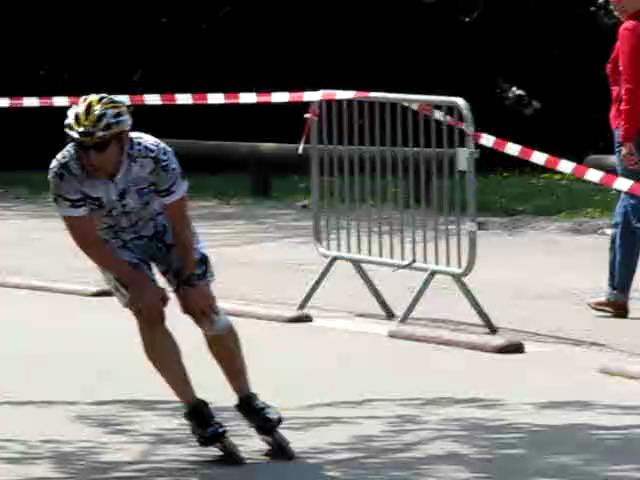
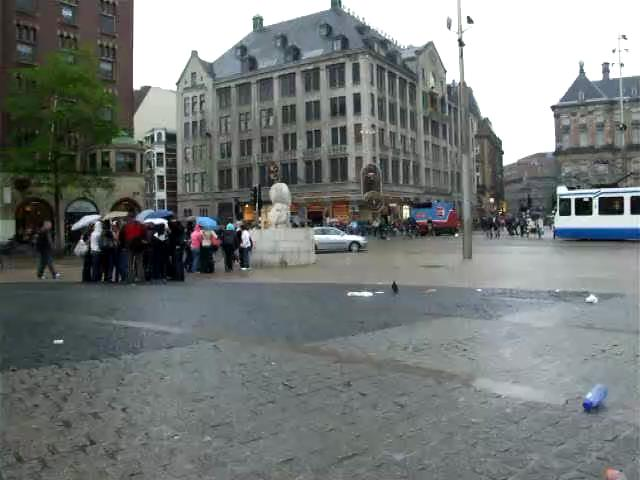
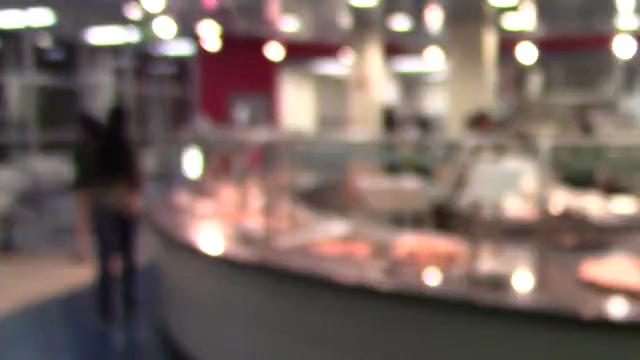

In [5]:
videos_table.show()

## Create a Label Studio project

Next we'll create a new Label Studio project and link it to a new view on the Pixeltable table. You can link a Label Studio project to either a table or a view. For tables that are expecting a lot of input data, it's often easier to link to views. In this example, we'll create a view that filters the table down by date.

In [6]:
from pixeltable.datatransfer.label_studio import LabelStudioProject

# Create a view to filter on the specified date

v = pxt.create_view(
    'ls_demo.videos_2024_04_22',
    videos_table,
    filter=(videos_table.date == today)
)

# Add a column to the view to receive the annotations. The column
# that receives the annotations must always have the type
# `pxt.JsonType(nullable=True)`.

v['annotations'] = pxt.JsonType(nullable=True)

# Create a new Label Studio project that we will link to the view.
# We use the pixeltable `LabelStudioProject.create` method for this,
# which both creates the project in Label Studio and initializes a
# Pixeltable reference to it.

ls_project = LabelStudioProject.create(
    title='ls_demo.videos_2024_04_22',
    label_config='''
    <View>
      <Video name="video" value="$video"/>
      <Choices name="video-category" toName="video" showInLine="true">
        <Choice value="city"/>
        <Choice value="food"/>
        <Choice value="sports"/>
      </Choices>
    </View>
    '''
)

# Now link the view and the project. This only needs to be done once:
# after the view and project are linked, the relationship is stored
# indefinitely in Pixeltable's metadata.

v.link_remote(ls_project)

Inserting rows into `videos_2024_04_22`: 3 rows [00:00, 2264.34 rows/s]
Created view `videos_2024_04_22` with 3 rows, 0 exceptions.
Added 3 column values with 0 errors.
Linked remote LabelStudioProject `ls_demo.videos_2024_04_22` to table `videos_2024_04_22`.


If you look in the Label Studio UI now, you'll see that there's a new project with the name `ls_demo.videos_2022_04_22`. There are no tasks in it: all we've done is to establish a link between the Pixeltable view and Label Studio project; we haven't actually synchronized the data between them yet.

Note that we didn't have to specify an explicit mapping between Pixeltable columns and Label Studio data fields. This is because, by default, Pixeltable assumes the Pixeltable and Label Studio field names coincide. The data field in the Label Studio project has the name `$video`, which Pixeltable maps, by default, to the column in `ls_demo.videos_2024_02_22` that is also called `video`. If you want to override this behavior to specify an explict mapping of columns to fields, you can do that with the `col_mapping` parameter of `link_remote()`.

## Push Videos from the View to the Label Studio Project

Now let's actually push our videos from the view to the Label Studio project. Once the link has been established, all we need to do is call the `sync_remotes()` command on the view.

In [7]:
v.sync_remotes()

Created 3 new task(s) in LabelStudioProject `ls_demo.videos_2024_04_22`.


Pixeltable remembers which videos have been synced, so if we call `sync_remotes()` again, it will only create new tasks for videos that have been added to the table since the last sync.

In [8]:
v.sync_remotes()

Created 0 new task(s) in LabelStudioProject `ls_demo.videos_2024_04_22`.
Synced 0 annotation(s) from 3 existing task(s) in LabelStudioProject `ls_demo.videos_2024_04_22`.


## Some Time Later, Pull the Annotations

Now let's try pulling some annotations from Label Studio back to our view. As always, Pixeltable retains all its data and state in persistent storage, so we can safely clear the variables in our Jupyter notebook or restart the kernel, then pick up seamlessly where we left off.

At this point, try creating annotations for one of the videos using the Label Studio UI (click an appropriate box next to the video category, then click `Submit`). Then come back to the notebook, optionally restart your Jupyter kernel, and enter the following command.

In [9]:
%reset -f
import pixeltable as pxt

v = pxt.get_table('ls_demo.videos_2024_04_22')
v.sync_remotes()

Created 0 new task(s) in LabelStudioProject `ls_demo.videos_2024_04_22`.
Synced 1 annotation(s) from 3 existing task(s) in LabelStudioProject `ls_demo.videos_2024_04_22`.


Let's see what effect that had.

video,annotations
,"[{'id': 23, 'task': 20, 'result': [{'id': '7Qx6UvlTu_', 'type': 'choices', 'value': {'choices': ['sports']}, 'origin': 'manual', 'to_name': 'video', 'from_name': 'video-category'}], 'project': 61, 'import_id': None, 'lead_time': 4.149, 'created_at': '2024-06-03T23:48:06.533749Z', 'updated_at': '2024-06-03T23:48:06.533775Z', 'updated_by': 1, 'created_ago': '0 minutes', 'last_action': None, 'completed_by': 1, 'ground_truth': False, 'was_cancelled': False, 'last_created_by': None, 'created_username': ' aaron.n.siegel@gmail.com, 1', 'draft_created_at': None, 'parent_annotation': None, 'parent_prediction': None}]"
,None
,None

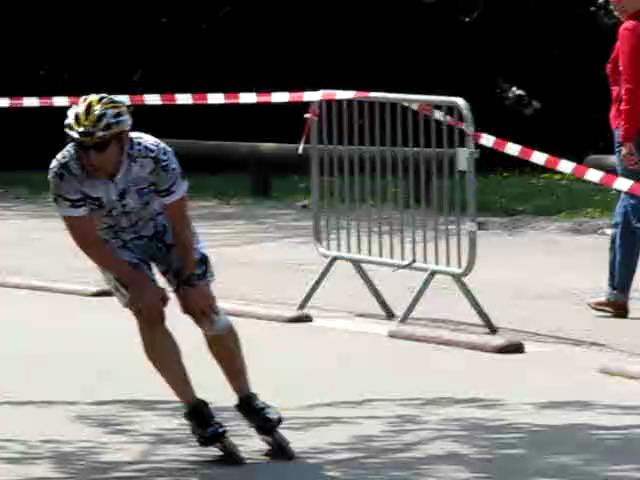
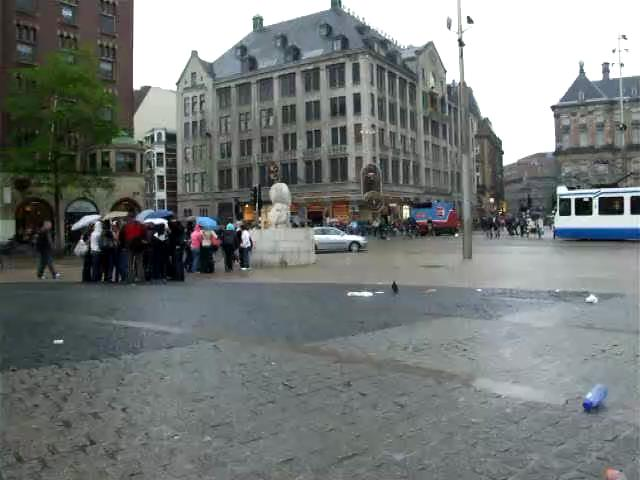
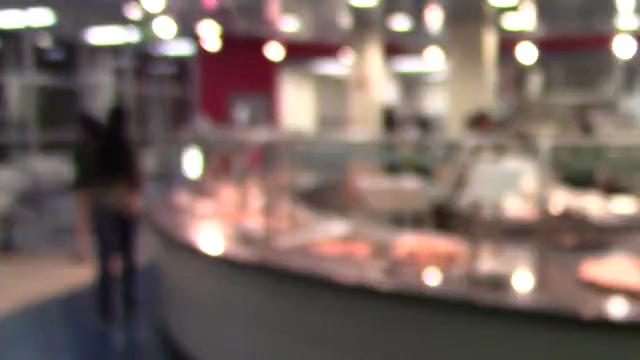

In [10]:
v.select(v.video, v.annotations).show()

## Parse Annotations with a Computed Column

Pixeltable pulls in all sorts of metadata from Label Studio during a sync: everything that Label Studio reports back about the annotations, including things like the user account that created the annotations. Let's say that all we care about is the annotation value. We can add a computed column to our table to pull it out.

Computing cells: 100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 417.19 cells/s]
Added 3 column values with 0 errors.


video,annotations,video_category
,"[{'id': 23, 'task': 20, 'result': [{'id': '7Qx6UvlTu_', 'type': 'choices', 'value': {'choices': ['sports']}, 'origin': 'manual', 'to_name': 'video', 'from_name': 'video-category'}], 'project': 61, 'import_id': None, 'lead_time': 4.149, 'created_at': '2024-06-03T23:48:06.533749Z', 'updated_at': '2024-06-03T23:48:06.533775Z', 'updated_by': 1, 'created_ago': '0 minutes', 'last_action': None, 'completed_by': 1, 'ground_truth': False, 'was_cancelled': False, 'last_created_by': None, 'created_username': ' aaron.n.siegel@gmail.com, 1', 'draft_created_at': None, 'parent_annotation': None, 'parent_prediction': None}]",sports
,None,None
,None,None

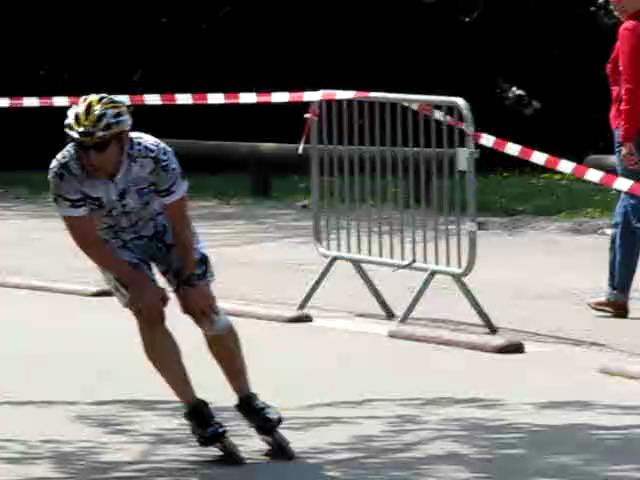
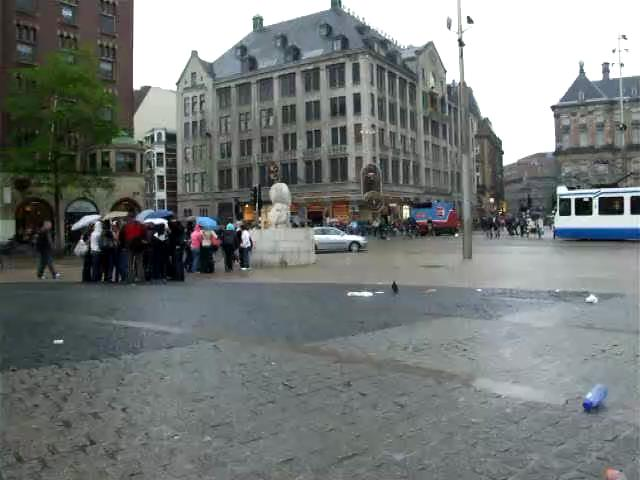
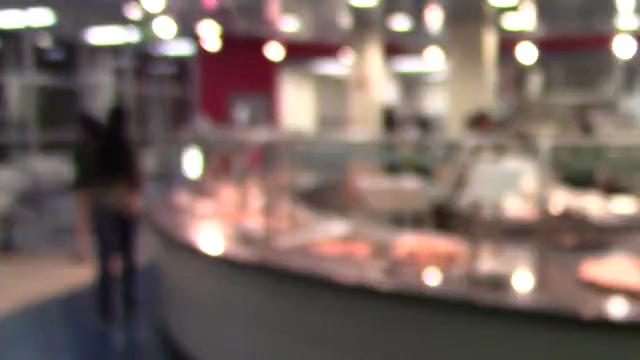

In [11]:
v['video_category'] = v.annotations[0].result[0].value.choices[0]
v.select(v.video, v.annotations, v.video_category).show()

Another useful operation is the `get_metadata` function, which returns information about the video itself, such as the resolution and codec (independent of Label Studio). Let's add another computed column to hold such metadata.

Computing cells: 100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 139.85 cells/s]
Added 3 column values with 0 errors.


video,annotations,video_category,video_metadata
,"[{'id': 23, 'task': 20, 'result': [{'id': '7Qx6UvlTu_', 'type': 'choices', 'value': {'choices': ['sports']}, 'origin': 'manual', 'to_name': 'video', 'from_name': 'video-category'}], 'project': 61, 'import_id': None, 'lead_time': 4.149, 'created_at': '2024-06-03T23:48:06.533749Z', 'updated_at': '2024-06-03T23:48:06.533775Z', 'updated_by': 1, 'created_ago': '0 minutes', 'last_action': None, 'completed_by': 1, 'ground_truth': False, 'was_cancelled': False, 'last_created_by': None, 'created_username': ' aaron.n.siegel@gmail.com, 1', 'draft_created_at': None, 'parent_annotation': None, 'parent_prediction': None}]",sports,"{'size': 815026, 'streams': [{'width': 640, 'frames': 235, 'height': 480, 'pix_fmt': 'yuv420p', 'duration': 235235, 'language': 'eng', 'base_rate': 29.97002997002997, 'average_rate': 29.97002997002997, 'guessed_rate': 29.97002997002997}], 'bit_rate': 828326, 'metadata': {'major_brand': 'mp42', 'creation_time': '2010-04-27T16:40:32.000000Z', 'minor_version': '0', 'compatible_brands': 'isom'}, 'bit_exact': False}"
,None,None,"{'size': 1558736, 'streams': [{'width': 640, 'frames': 450, 'height': 480, 'pix_fmt': 'yuv420p', 'duration': 450450, 'language': 'eng', 'base_rate': 29.97002997002997, 'average_rate': 29.97002997002997, 'guessed_rate': 29.97002997002997}], 'bit_rate': 828756, 'metadata': {'major_brand': 'mp42', 'creation_time': '2009-05-20T00:53:00.000000Z', 'minor_version': '0', 'compatible_brands': 'isom'}, 'bit_exact': False}"
,None,None,"{'size': 2099014, 'streams': [{'width': 640, 'frames': 600, 'height': 360, 'pix_fmt': 'yuv420p', 'duration': 600600, 'language': 'eng', 'base_rate': 29.97002997002997, 'average_rate': 29.97002997002997, 'guessed_rate': 29.97002997002997}], 'bit_rate': 836844, 'metadata': {'encoder': 'Lavf54.63.104', 'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41'}, 'bit_exact': False}"

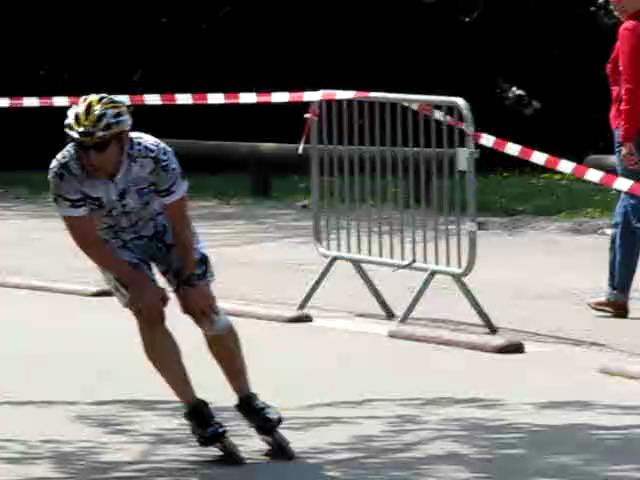
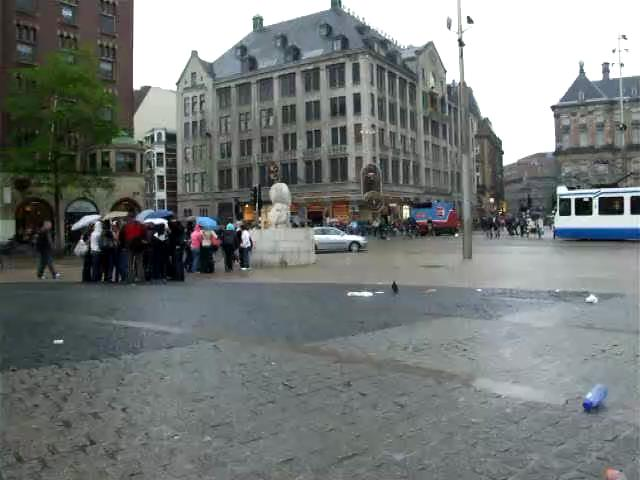
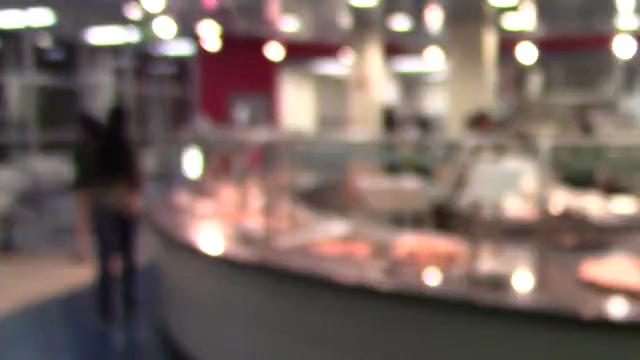

In [12]:
from pixeltable.functions.video import get_metadata

v['video_metadata'] = get_metadata(v.video)
v.select(v.video, v.annotations, v.video_category, v.video_metadata).show()

## Preannotations with Pixeltable and Label Studio

Frame extraction is another common operation in labeling workflows. In this example, we'll extract frames from our videos into a view, then use an object detection model to generate preannotations for each frame. The following code uses a Pixeltable `FrameIterator` to automatically extract frames into a new view, which we'll call `frames_2024_04_22`.

In [13]:
from datetime import date
from pixeltable.iterators import FrameIterator

today = date(2022, 4, 22)
videos_table = pxt.get_table('ls_demo.videos')
pxt.drop_table('ls_demo.frames_2024_04_22', ignore_errors=True)

# Create the view, using a `FrameIterator` to extract frames with a sample rate
# of `fps=0.25`, or 1 frame per 4 seconds of video. Setting `fps=0` would use the
# native framerate of the video, extracting every frame.

frames = pxt.create_view(
    'ls_demo.frames_2024_04_22',
    videos_table,
    filter=(videos_table.date == today),
    iterator=FrameIterator.create(video=videos_table.video, fps=0.25)
)

Inserting rows into `frames_2024_04_22`: 13 rows [00:00, 9931.87 rows/s]
Created view `frames_2024_04_22` with 13 rows, 0 exceptions.


frame
""
""
""
""
""
""
""
""
""
""

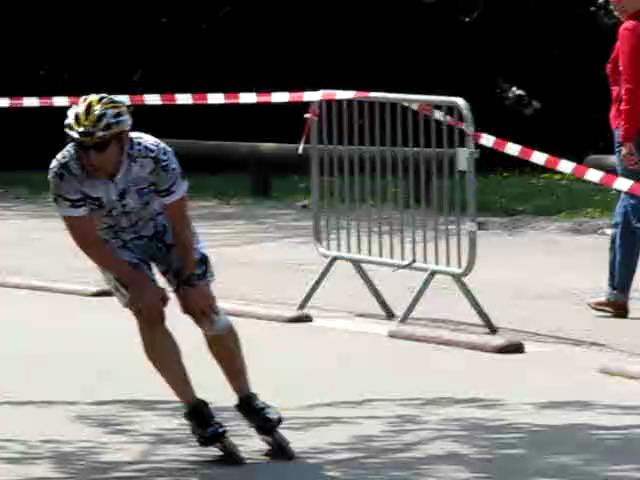
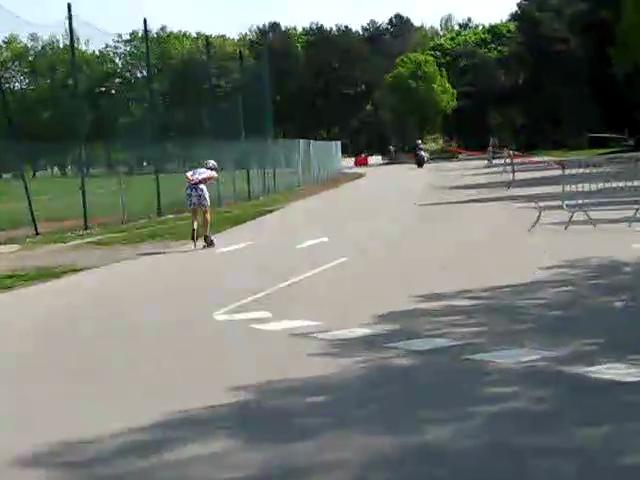
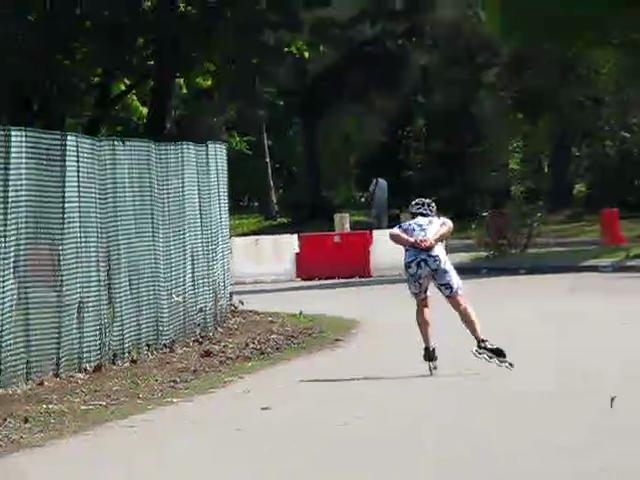
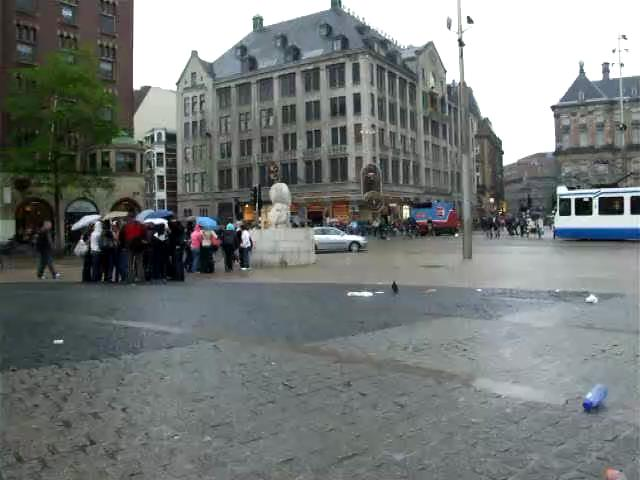
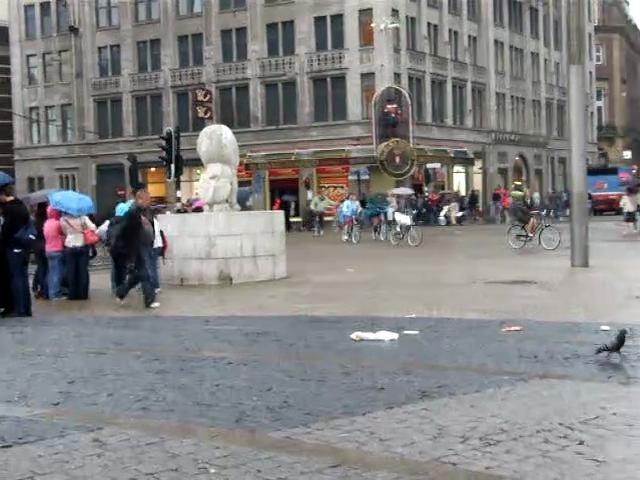
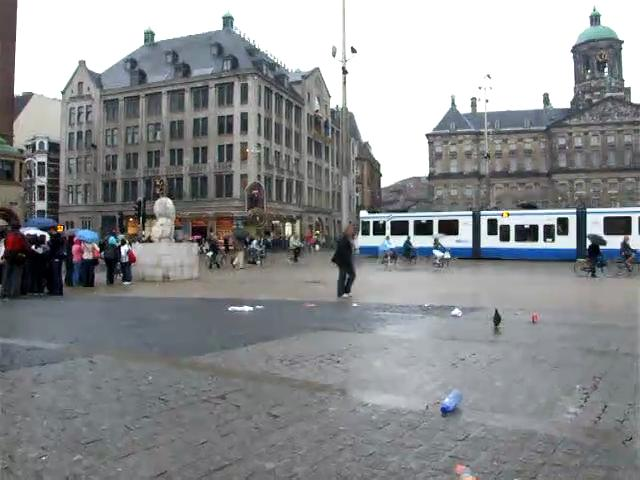
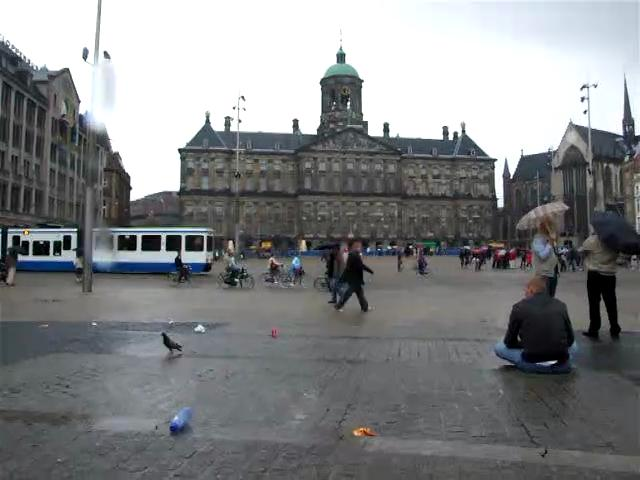
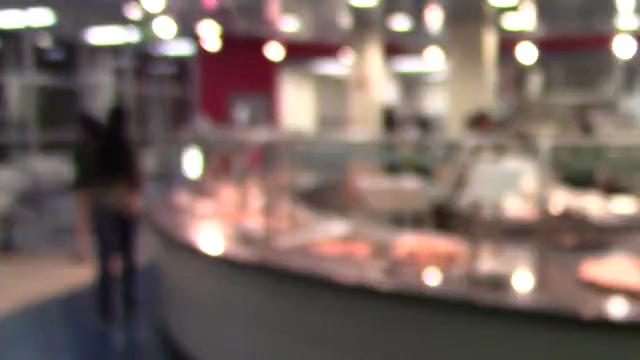
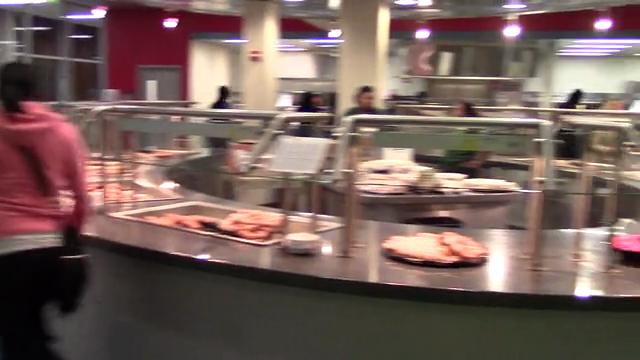
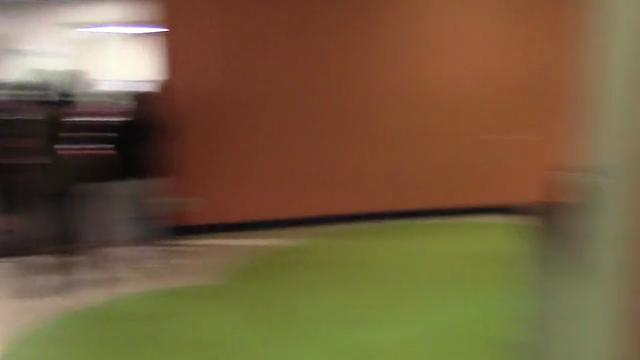
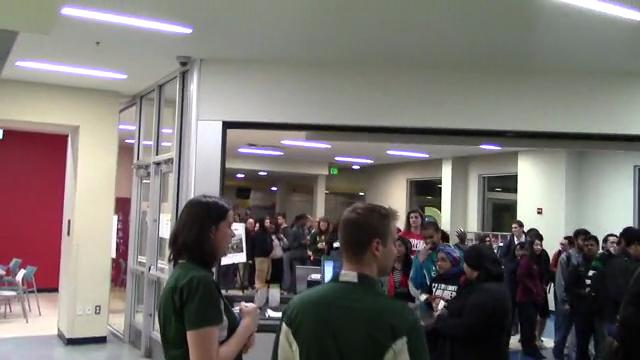
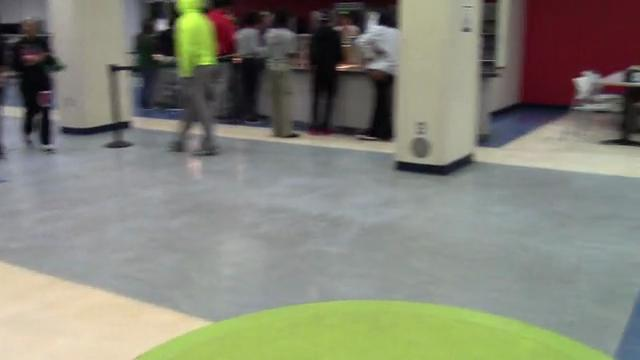
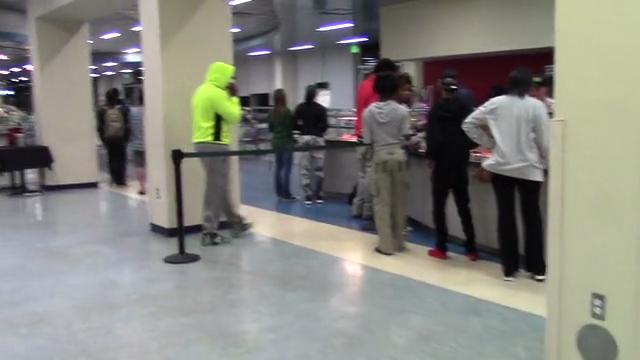

In [14]:
frames.select(frames.frame).show()

Now we'll use the Resnet-50 object detection model to generate preannotations. We do this by creating a new computed column.

Computing cells: 100%|██████████████████████████████████████████| 13/13 [00:05<00:00,  2.33 cells/s]
Added 13 column values with 0 errors.


frame,detections
,"{'boxes': [[584.916259765625, 0.7495594024658203, 639.98876953125, 321.3192138671875], [46.76612854003906, 93.5486831665039, 294.69342041015625, 465.5838623046875]], 'labels': [1, 1], 'scores': [0.9954984188079834, 0.9991014003753662], 'label_text': ['person', 'person']}"
,"{'boxes': [[562.8792724609375, 196.99993896484375, 640.2057495117188, 229.3076171875], [415.18524169921875, 149.3098907470703, 427.4687194824219, 168.12136840820312], [182.4439697265625, 160.578125, 219.7430419921875, 248.85458374023438], [413.59912109375, 139.34494018554688, 426.32952880859375, 160.36627197265625]], 'labels': [15, 4, 1, 1], 'scores': [0.9813884496688843, 0.9949589371681213, 0.9995488524436951, 0.9877305626869202], 'label_text': ['bench', 'motorcycle', 'person', 'person']}"
,"{'boxes': [[387.7949523925781, 196.153564453125, 505.8482360839844, 372.0858154296875]], 'labels': [1], 'scores': [0.9995471835136414], 'label_text': ['person']}"
,"{'boxes': [[122.22232055664062, 217.60226440429688, 146.6725616455078, 283.2918395996094], [238.65577697753906, 224.6175994873047, 254.94564819335938, 270.92626953125], [137.73402404785156, 209.83152770996094, 170.65640258789062, 220.5065460205078], [552.21630859375, 185.43399047851562, 639.8759765625, 241.1767120361328], [31.22624397277832, 219.2633514404297, 59.837425231933594, 280.576171875], [191.96182250976562, 216.0517120361328, 217.99903869628906, 226.33567810058594], [68.70598602294922, 214.7066650390625, 97.59748840332031, 228.4792938232422], [311.01953125, 226.5934600830078, 365.77490234375, 253.30618286132812], [411.6280822753906, 200.0233917236328, 459.6242980957031, 234.30975341796875]], 'labels': [1, 1, 28, 6, 1, 28, 28, 3, 6], 'scores': [0.9564302563667297, 0.991428554058075, 0.9930250644683838, 0.9982154369354248, 0.9811825156211853, 0.9939857125282288, 0.9799979329109192, 0.9985119700431824, 0.9567760825157166], 'label_text': ['person', 'person', 'umbrella', 'bus', 'person', 'umbrella', 'umbrella', 'car', 'bus']}"
,"{'boxes': [[39.429534912109375, 206.39036560058594, 66.30303955078125, 300.87451171875], [46.86207580566406, 191.11488342285156, 94.74597930908203, 214.825439453125], [504.3735046386719, 210.84568786621094, 561.6031494140625, 250.90570068359375], [594.998291015625, 330.30694580078125, 626.0513916015625, 359.1400451660156], [587.6251831054688, 186.7899932861328, 623.58837890625, 216.67269897460938], [139.72509765625, 196.63719177246094, 168.3582763671875, 302.72637939453125], [312.299072265625, 216.5193328857422, 325.3564758300781, 238.79258728027344], [-0.047872066497802734, 172.94493103027344, 37.676795959472656, 319.7128601074219], [67.37471008300781, 219.4443817138672, 98.17986297607422, 248.42262268066406], [338.6128234863281, 193.8282470703125, 360.75872802734375, 236.9286346435547], [157.46205139160156, 129.111083984375, 173.669189453125, 173.5928955078125], [109.83171081542969, 189.35357666015625, 160.84130859375, 308.6635437011719], [57.44021987915039, 205.60166931152344, 97.0779037475586, 302.0231628417969], [392.765380859375, 216.64120483398438, 422.8740234375, 245.40115356445312], [343.98553466796875, 218.2808380126953, 363.1180419921875, 244.033447265625], [387.5203857421875, 185.65379333496094, 415.7756042480469, 197.39170837402344]], 'labels': [1, 28, 2, 16, 3, 1, 2, 1, 31, 1, 10, 1, 1, 2, 2, 28], 'scores': [0.9787867665290833, 0.9939237236976624, 0.9981405735015869, 0.9636640548706055, 0.9539715647697449, 0.958773136138916, 0.9749516844749451, 0.9878109097480774, 0.9614275097846985, 0.9842295050621033, 0.9917214512825012, 0.9901456236839294, 0.9848958253860474, 0.9921109676361084, 0.9801077842712402, 0.9682183265686035], 'label_text': ['person', 'umbrella', 'bicycle', 'bird', 'car', 'person', 'bicycle', 'person', 'handbag', 'person', 'traffic light', 'person', 'person', 'bicycle', 'bicycle', 'umbrella']}"
,"{'boxes': [[121.31318664550781, 238.0507049560547, 136.68502807617188, 285.7488708496094], [621.933837890625, 233.48216247558594, 636.926879
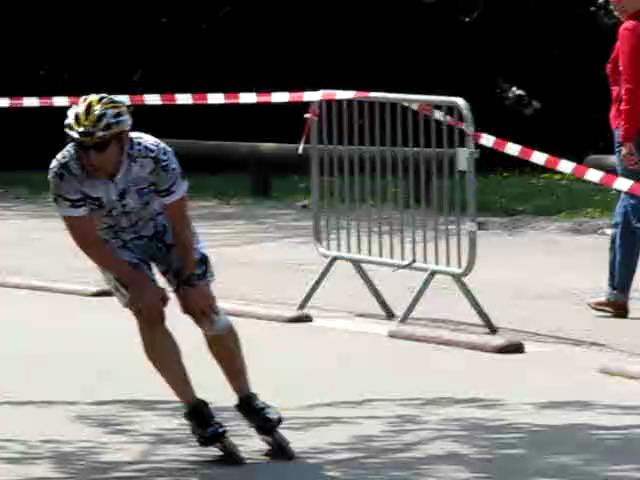
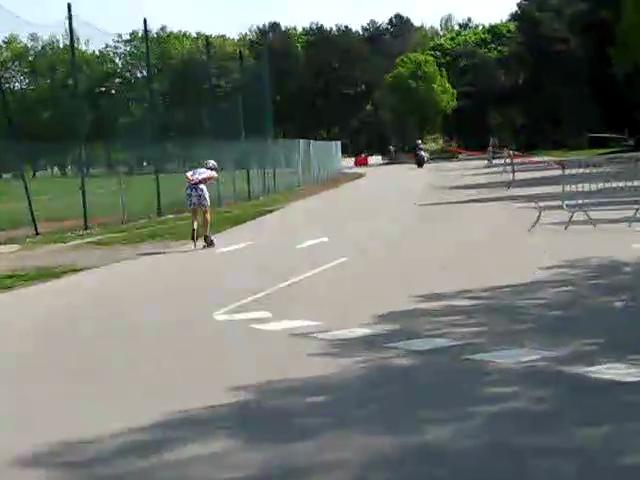
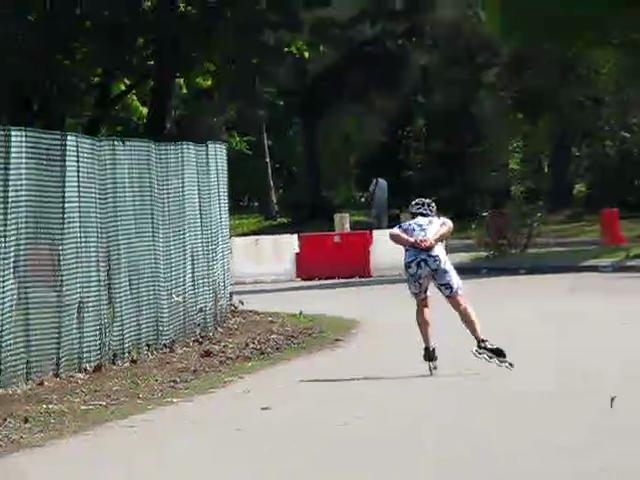
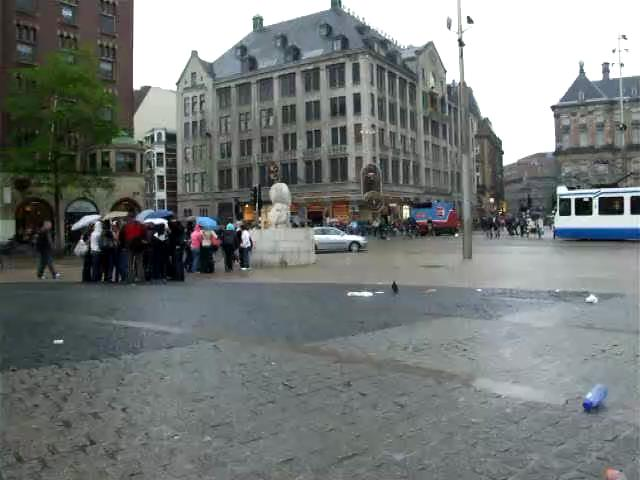
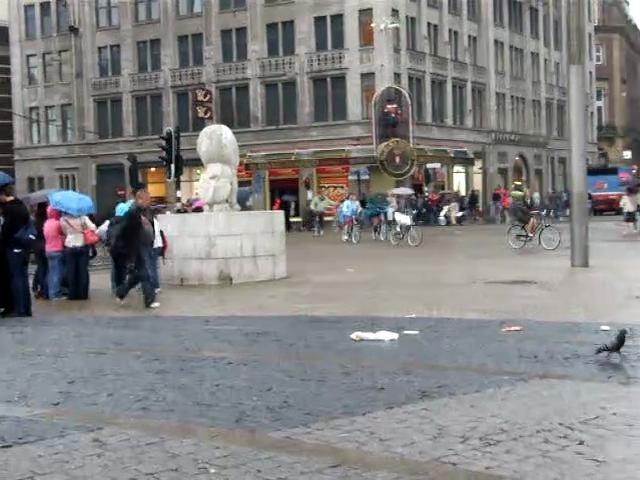
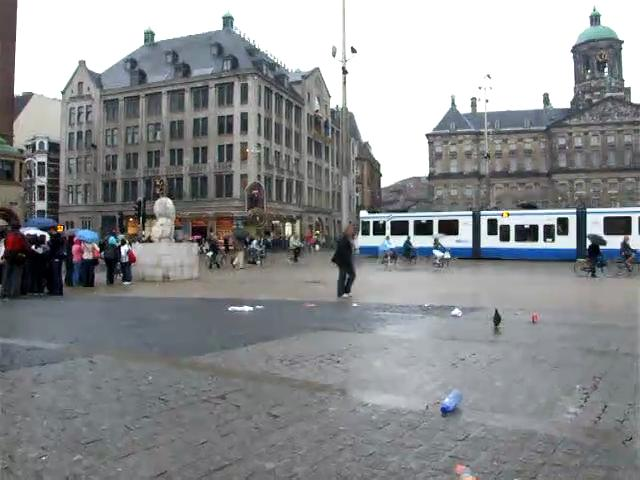
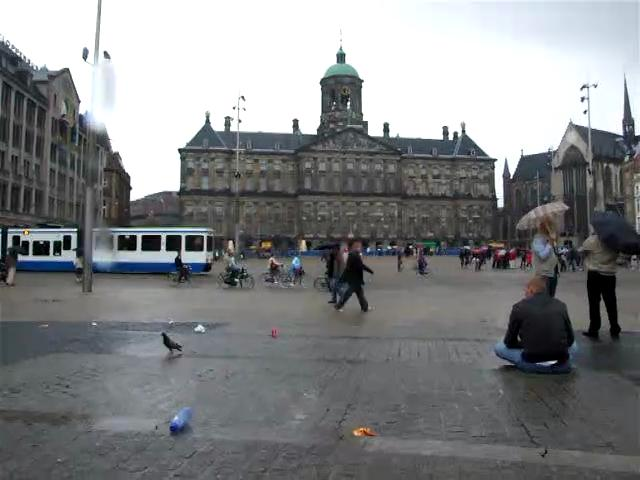
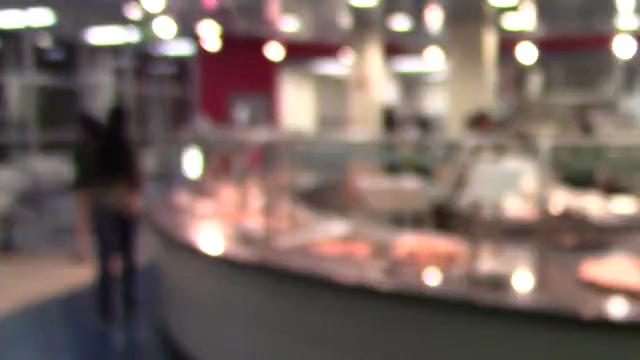
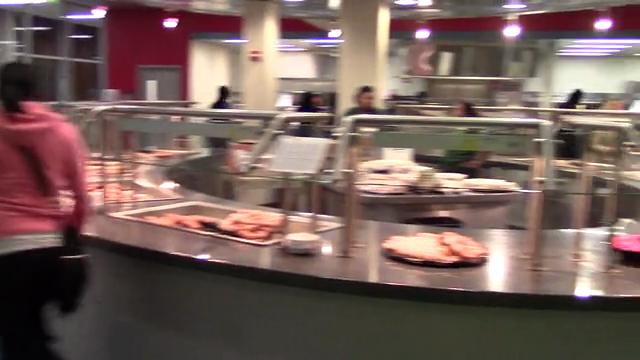
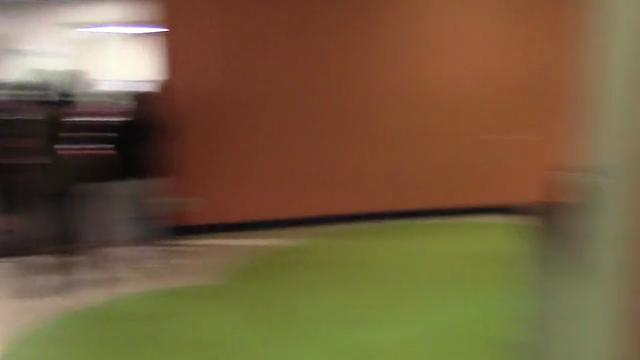
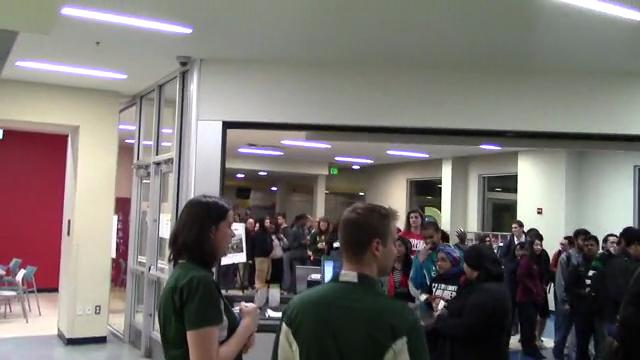
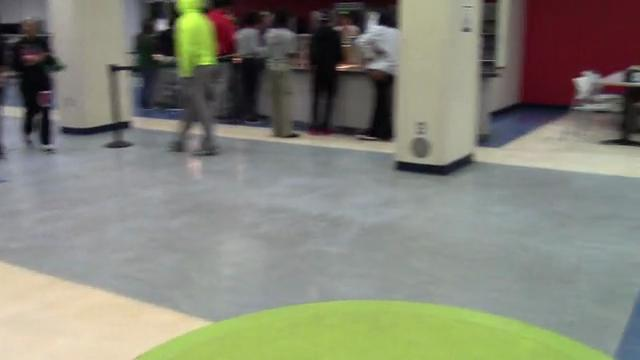
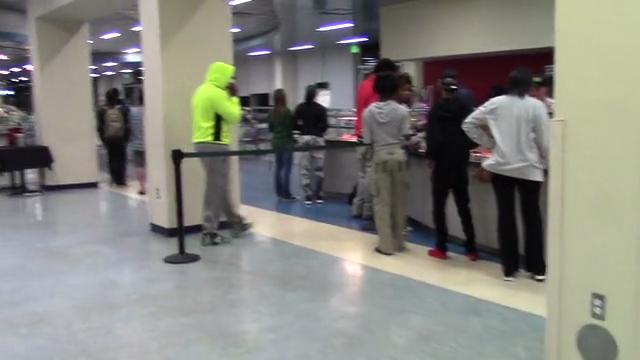

In [15]:
from pixeltable.functions.huggingface import detr_for_object_detection, detr_to_coco

# Run the Resnet-50 object detection model against each frame to generate bounding boxes
frames['detections'] = detr_for_object_detection(frames.frame, model_id='facebook/detr-resnet-50', threshold=0.95)
frames.select(frames.frame, frames.detections).show()

We'd like to send these detections to Label Studio as preannotations, but they're not quite ready. Label Studio expects preannotations in standard COCO format, but the Huggingface library outputs them in its own custom format. We can use Pixeltable's handy `detr_to_coco` function to do the conversion, using another computed column.

Computing cells: 100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 39.84 cells/s]
Added 13 column values with 0 errors.


frame,detections,preannotations
,"{'boxes': [[584.916259765625, 0.7495594024658203, 639.98876953125, 321.3192138671875], [46.76612854003906, 93.5486831665039, 294.69342041015625, 465.5838623046875]], 'labels': [1, 1], 'scores': [0.9954984188079834, 0.9991014003753662], 'label_text': ['person', 'person']}","{'image': {'width': 640, 'height': 480}, 'annotations': [{'bbox': [584.916259765625, 0.7495594024658203, 55.072509765625, 320.5696544647217], 'category': 1}, {'bbox': [46.76612854003906, 93.5486831665039, 247.9272918701172, 372.0351791381836], 'category': 1}]}"
,"{'boxes': [[562.8792724609375, 196.99993896484375, 640.2057495117188, 229.3076171875], [415.18524169921875, 149.3098907470703, 427.4687194824219, 168.12136840820312], [182.4439697265625, 160.578125, 219.7430419921875, 248.85458374023438], [413.59912109375, 139.34494018554688, 426.32952880859375, 160.36627197265625]], 'labels': [15, 4, 1, 1], 'scores': [0.9813884496688843, 0.9949589371681213, 0.9995488524436951, 0.9877305626869202], 'label_text': ['bench', 'motorcycle', 'person', 'person']}","{'image': {'width': 640, 'height': 480}, 'annotations': [{'bbox': [562.8792724609375, 196.99993896484375, 77.32647705078125, 32.30767822265625], 'category': 15}, {'bbox': [415.18524169921875, 149.3098907470703, 12.283477783203125, 18.811477661132812], 'category': 4}, {'bbox': [182.4439697265625, 160.578125, 37.299072265625, 88.27645874023438], 'category': 1}, {'bbox': [413.59912109375, 139.34494018554688, 12.73040771484375, 21.021331787109375], 'category': 1}]}"
,"{'boxes': [[387.7949523925781, 196.153564453125, 505.8482360839844, 372.0858154296875]], 'labels': [1], 'scores': [0.9995471835136414], 'label_text': ['person']}","{'image': {'width': 640, 'height': 480}, 'annotations': [{'bbox': [387.7949523925781, 196.153564453125, 118.05328369140625, 175.9322509765625], 'category': 1}]}"
,"{'boxes': [[122.22232055664062, 217.60226440429688, 146.6725616455078, 283.2918395996094], [238.65577697753906, 224.6175994873047, 254.94564819335938, 270.92626953125], [137.73402404785156, 209.83152770996094, 170.65640258789062, 220.5065460205078], [552.21630859375, 185.43399047851562, 639.8759765625, 241.1767120361328], [31.22624397277832, 219.2633514404297, 59.837425231933594, 280.576171875], [191.96182250976562, 216.0517120361328, 217.99903869628906, 226.33567810058594], [68.70598602294922, 214.7066650390625, 97.59748840332031, 228.4792938232422], [311.01953125, 226.5934600830078, 365.77490234375, 253.30618286132812], [411.6280822753906, 200.0233917236328, 459.6242980957031, 234.30975341796875]], 'labels': [1, 1, 28, 6, 1, 28, 28, 3, 6], 'scores': [0.9564302563667297, 0.991428554058075, 0.9930250644683838, 0.9982154369354248, 0.9811825156211853, 0.9939857125282288, 0.9799979329109192, 0.9985119700431824, 0.9567760825157166], 'label_text': ['person', 'person', 'umbrella', 'bus', 'person', 'umbrella', 'umbrella', 'car', 'bus']}","{'image': {'width': 640, 'height': 480}, 'annotations': [{'bbox': [122.22232055664062, 217.60226440429688, 24.450241088867188, 65.6895751953125], 'category': 1}, {'bbox': [238.65577697753906, 224.6175994873047, 16.289871215820312, 46.30867004394531], 'category': 1}, {'bbox': [137.73402404785156, 209.83152770996094, 32.92237854003906, 10.675018310546875], 'category': 28}, {'bbox': [552.21630859375, 185.43399047851562, 87.65966796875, 55.74272155761719], 'category': 6}, {'bbox': [31.22624397277832, 219.2633514404297, 28.611181259155273, 61.31282043457031], 'category': 1}, {'bbox': [191.96182250976562, 216.0517120361328, 26.037216186523438, 10.283966064453125], 'category': 28}, {'bbox': [68.70598602294922, 214.7066650390625, 28.891502380371094, 13.772628784179688], 'category': 28}, {'bbox': [311.01953125, 226.5934600830078, 54.75537109375, 26.712722778320312], 'category': 3}, {'bbox': [411.6280822753906, 200.0233917236328, 47.9962158203125, 34.28636169433594], 'category': 6}]}"
,"{'boxes': [[39.429534912109375, 206.39036560058594, 66.30303955078125, 300.87451171875], [46.8
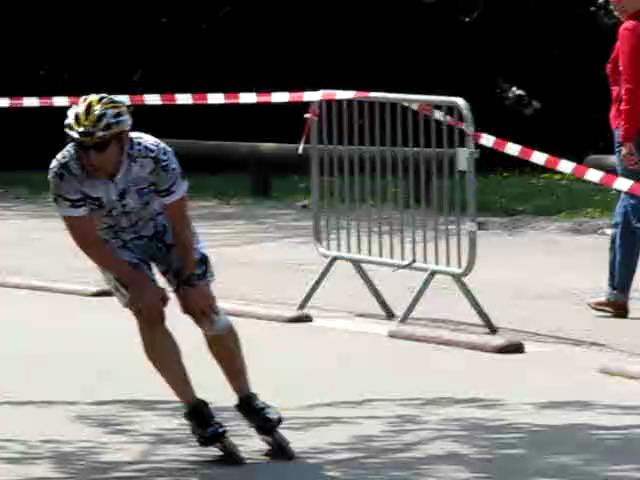
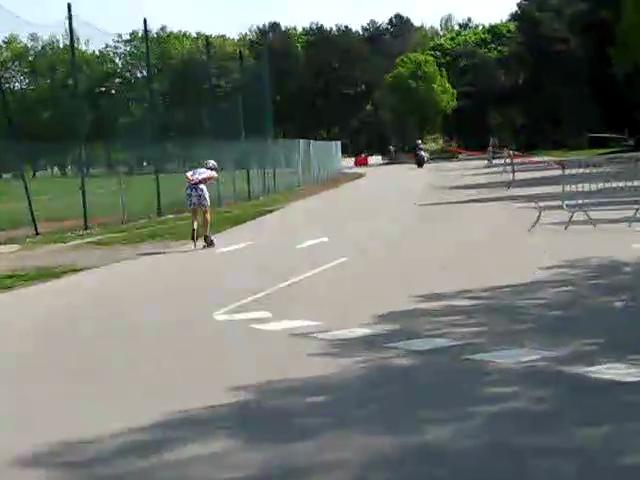
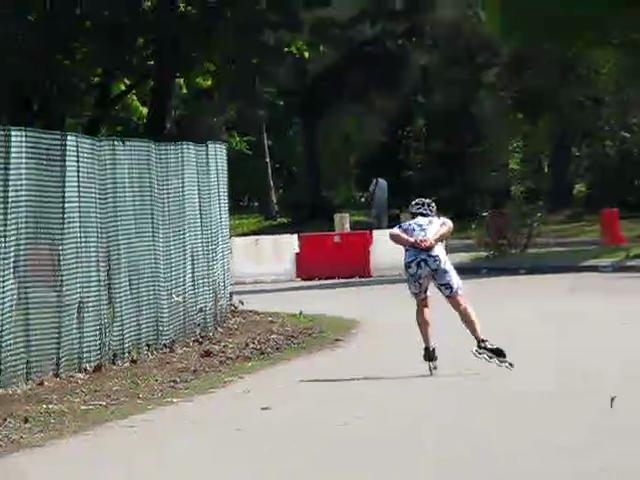
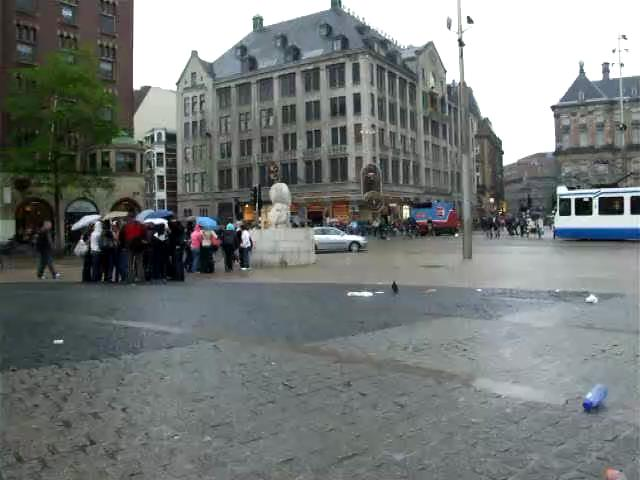
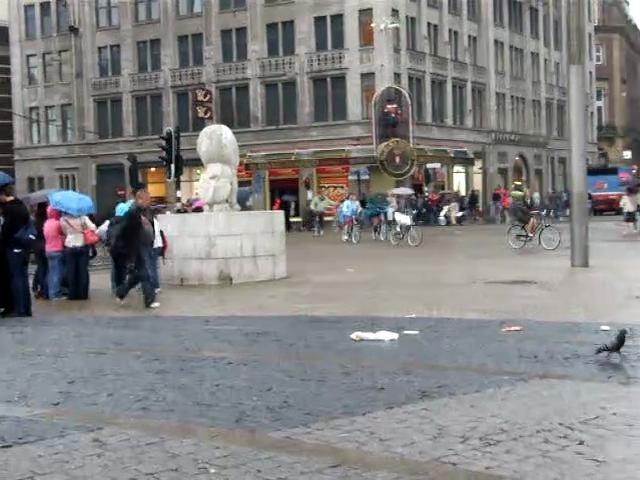
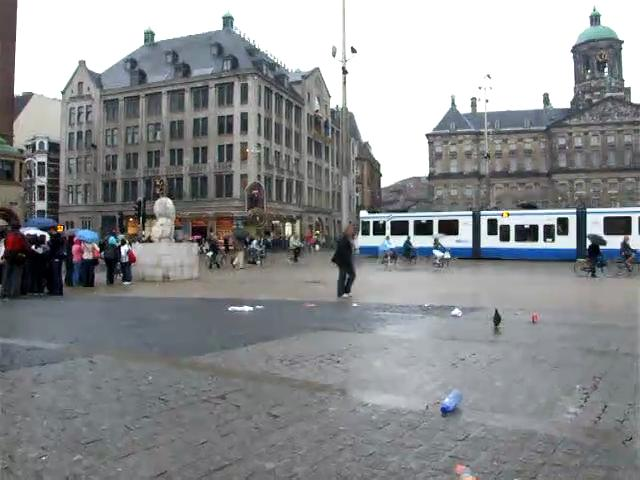
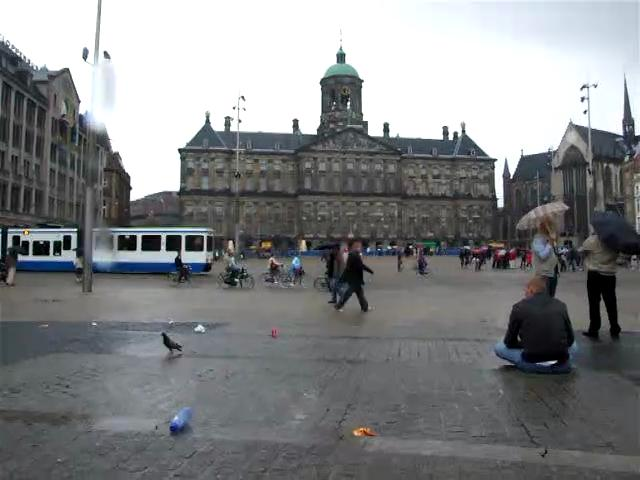
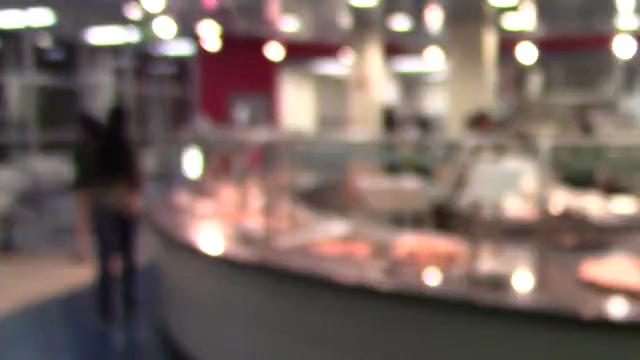
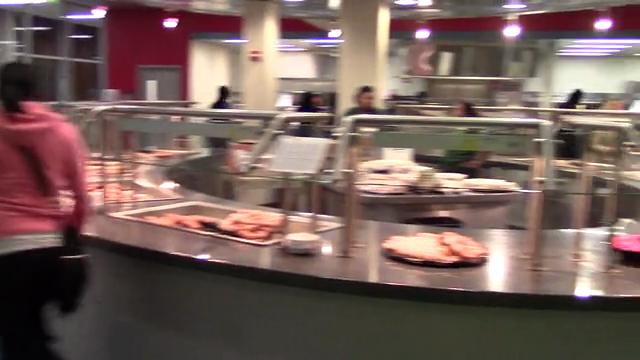
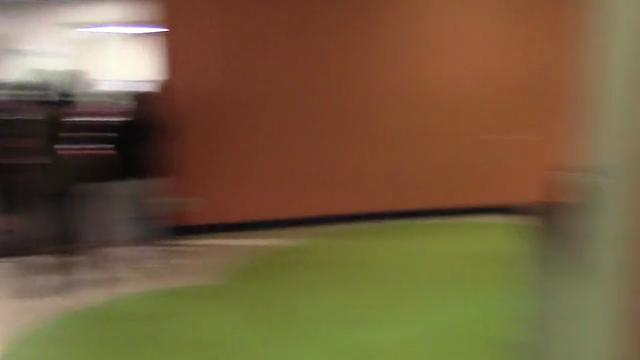
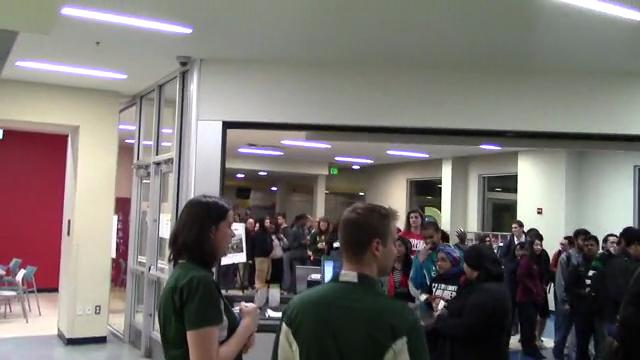
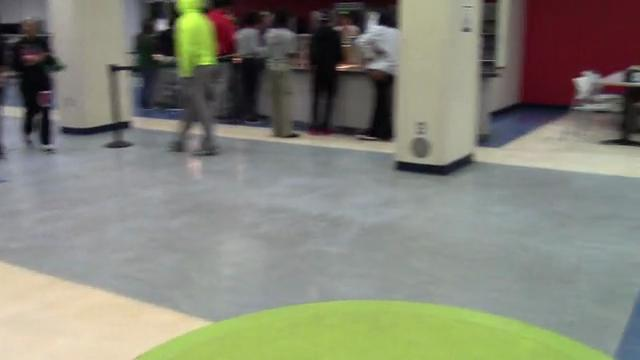
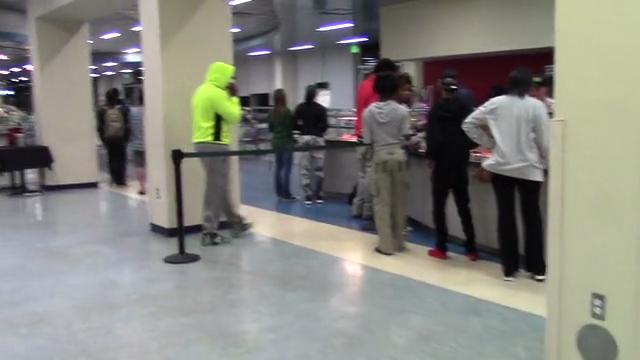

In [16]:
frames['preannotations'] = detr_to_coco(frames.frame, frames.detections)
frames.select(frames.frame, frames.detections, frames.preannotations).show()

## Create a Label Studio Project for Frames

With our data workflow set up and the COCO preannotations prepared, all that's left is to create a corresponding Label Studio project. Note how Pixeltable automatically maps `RectangleLabels` preannotation fields to columns, just like it does with data fields. Here, Pixeltable interprets the `name="preannotations"` attribute in `RectangleLabels` to mean, "map these rectangle labels to the `preannotations` column in my linked table or view".

The Label values `car`, `person`, and `train` are standard COCO object identifiers used by many off-the-shelf object detection models. You can find the complete list of them here, and include as many as you wish: https://raw.githubusercontent.com/aaron-siegel/pixeltable/label-studio/docs/release/coco-categories.csv

In [17]:
from pixeltable.datatransfer.label_studio import LabelStudioProject

frames['annotations'] = pxt.JsonType(nullable=True)

frames_project = LabelStudioProject.create(
    'ls_demo.frames_2024_04_22',
    '''
    <View>
      <Image name="frame" value="$frame"/>
      <RectangleLabels name="preannotations" toName="frame">
        <Label value="car" background="blue"/>
        <Label value="person" background="red"/>
        <Label value="train" background="green"/>
      </RectangleLabels>
    </View>
    '''
)

frames.link_remote(frames_project)

Added 13 column values with 0 errors.
Linked remote LabelStudioProject `ls_demo.frames_2024_04_22` to table `frames_2024_04_22`.


In [18]:
frames.sync_remotes()

Created 13 new task(s) in LabelStudioProject `ls_demo.frames_2024_04_22`.


If you go into Label Studio and open up the new project, you can see the effect of adding the preannotations from Resnet-50 to our workflow.